**ANALYSE DATASET : Satellite Landstat**



**Information et explication du dataset**

Ces données correspondent au "Statlog (Landsat Satellite) Data Set". Les données Landsat originales pour cette base de données ont été générées
à partir de données achetées à la NASA par le Centre australien
pour la télédétection, et utilisé pour la recherche par le  Centre de télédétection
Université de Nouvelle-Galles du Sud
Kensington, boîte postale 1
NSW 2033
L'Australie.

La base de données comprend les valeurs multispectrales des pixels des quartiers 3x3 d'une image satellite, et la classification associée au pixel central dans chaque quartier. La résolution spatiale d'un pixel est d'environ 80m x 80m. Chaque image contient 2340 x 3380 de ces pixels.

La base de données est une (minuscule) sous-zone d'une scène, composée de 82 x 100 pixels. Chaque ligne de données correspond à un quartier de 3x3 carrés de pixels entièrement contenus dans la sous-zone de 82x10. Chaque pixel est constitué de 4 valeurs numériques comprisent entre 0 et 255 correspondant à la couleur du pixel dans 4 grandes bandes spectrales : 
  - Bande Verte
  - Bande Rouge 
  - Bande Near Infrarouge 1
  - Bande Near Infrarouge 2
  
 Ce qui nous donnent 4 X 9 (3X3) = 36 colonnes + 1 colonne de classification = 37 colonnes.

Le but de cette analyse est de prédire cette classification, en utilisant  des valeurs multispectrales. Dans la base de données échantillon, la classe d'un pixel est codée sous forme de nombre. La classe à prédire correspond à des valeurs entre 1 et 7. Nous avons 4435 valeurs dans le training set et 2000 dans le testing set. 
C'est un dataset associée à une multi classififcation, le but étant de connaitre quel est la classe associé au pixel.

- Numéro de la classe :

  - 1 : terre rouge
  - 2 : la culture du coton
  - 3 : terre grise
  - 4 : sol gris humide
  - 5 : sol avec chaumes de végétation
  - 6 : classe de mélange (tous les types présents)
  - 7 : sol gris très humide
    - NB. Il n'y a pas d'exemples avec la classe 6 dans cet ensemble de données.


Les données sont données dans un ordre aléatoire et certaines lignes de données ont été supprimées pour ne pas reconstruire l'image originale à partir de cet ensemble de données. Dans chaque ligne de données, les quatre valeurs spectrales pour le pixel supérieur gauche sont données en premier, suivies des quatre valeurs spectrales pour le pixel moyen supérieur, puis de celles pour le pixel supérieur droit, et ainsi de suite avec les pixels lus en séquence de gauche à droite et de haut en bas.

Ainsi, les quatre valeurs spectrales pour le pixel central sont données par les attributs 17, 18, 19 et 20. La classification est assocé uniquement au pixel central

Nous avons réalisé un schéma qui explique ce dataset et qui resume nos dires précedents : 

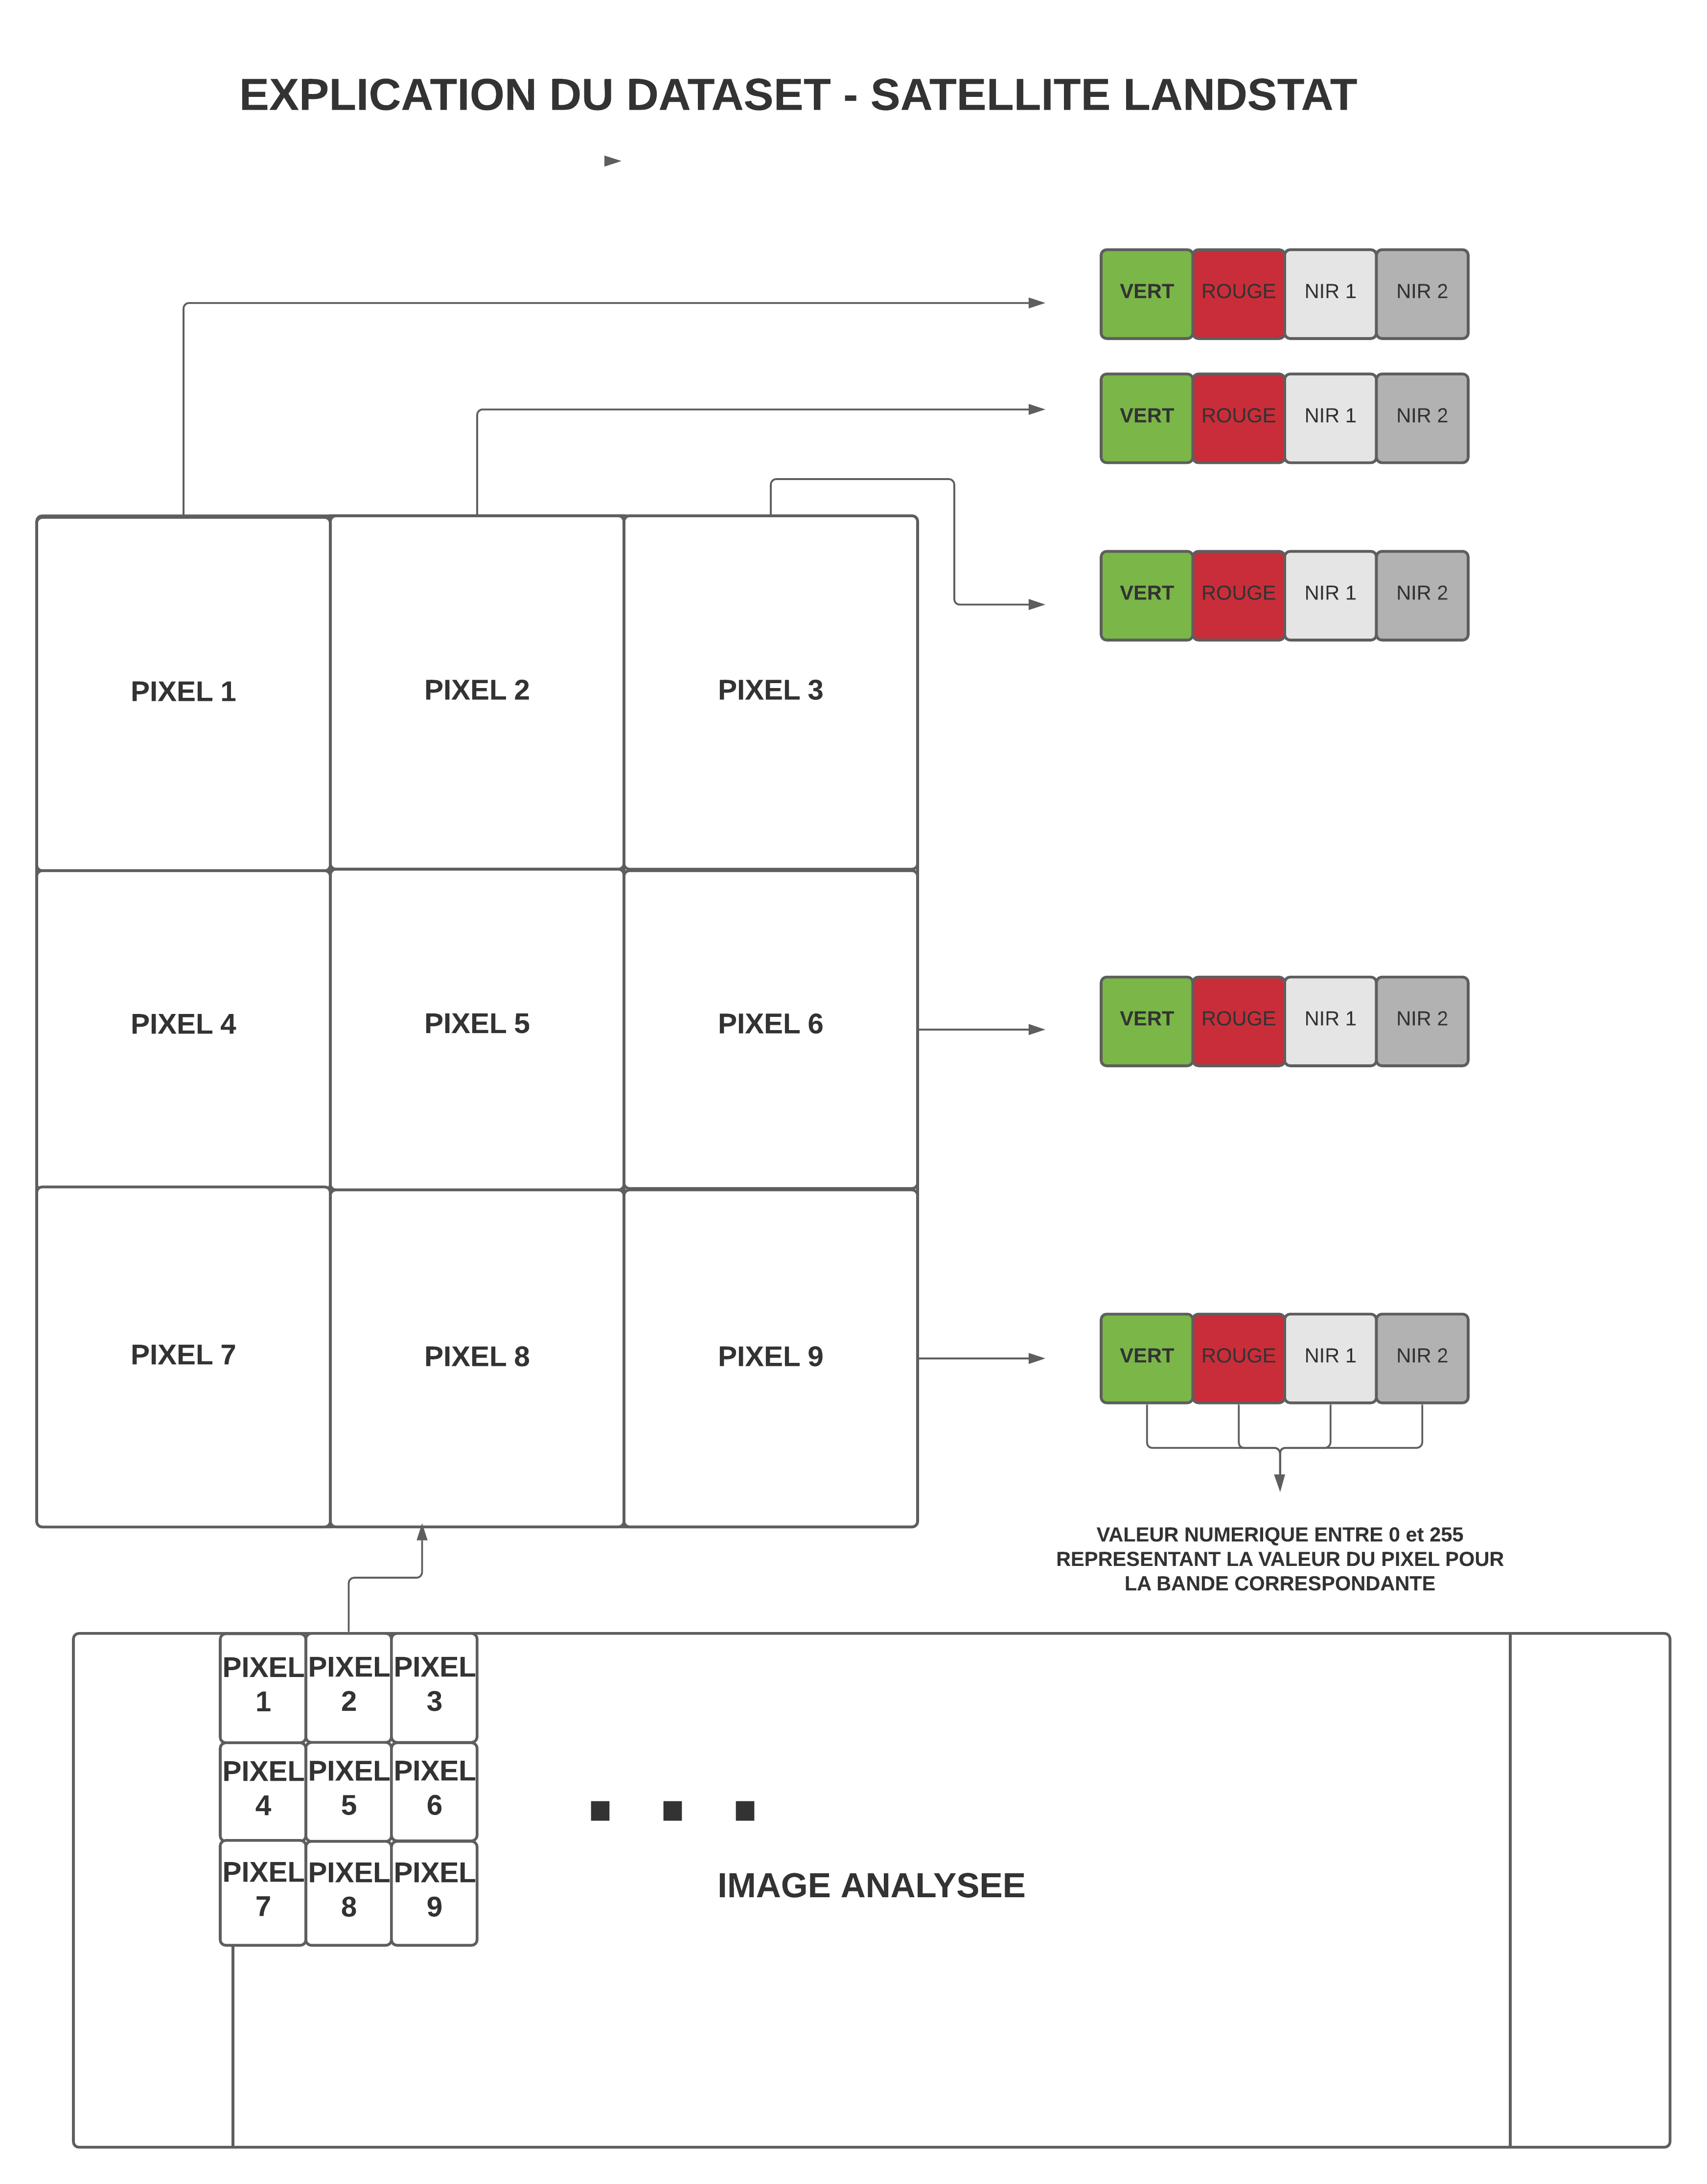



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
#Google Drive
url_to_test_set = '/content/drive/MyDrive/Colab Notebooks/Projet Python - Satellite/sat.tst'
url_to_training_set = '/content/drive/MyDrive/Colab Notebooks/Projet Python - Satellite/sat.trn'



**Imports**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
%matplotlib inline

import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import confusion_matrix


import joblib
sns.set()

**Récupération des données**

In [4]:
#Récupération du test set et affichage des 5 premières valeurs 

statlog_tst = pd.pandas.read_table(url_to_test_set)
statlog_tst.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,80,102,102,79,76,102,102,79,76,102,106,83,76,99,108,85,76,103,118,88,80,107,118,88,79,107,109,87,79,107,109,87,79,107,113,87,3
1,76,102,102,79,76,102,106,83,76,102,106,87,76,103,118,88,80,107,118,88,80,112,118,88,79,107,109,87,79,107,113,87,79,103,104,83,3
2,80,98,106,79,76,94,102,76,76,94,102,76,80,107,113,85,80,95,100,78,80,95,100,78,79,103,104,79,79,95,100,79,79,95,96,75,4
3,76,94,102,76,76,94,102,76,76,94,102,76,80,95,100,78,80,95,100,78,80,91,100,78,79,95,100,79,79,95,96,75,79,95,100,75,4
4,76,94,102,76,76,94,102,76,76,89,94,76,80,95,100,78,80,91,100,78,80,91,100,74,79,95,96,75,79,95,100,75,75,95,100,79,4


In [5]:
#Récupération du train set et affichage des 5 premières valeurs 
statlog_trn = pd.pandas.read_table(url_to_training_set)
statlog_trn.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,24.1,25,26,27,28,29,30,31,32,33,34,35,36,37
0,92,115,120,94,84,102,106,79,84,102,102,83,101,126,133,103,92,112,118,85,84,103,104,81,102,126,134,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,102,79,92,112,118,85,84,103,104,81,84,99,104,78,88,121,128,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,102,79,84,103,104,81,84,99,104,78,84,99,104,81,84,107,113,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,98,76,84,99,104,78,84,99,104,81,76,99,104,81,84,99,104,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,102,79,84,99,104,81,76,99,104,81,76,99,108,85,84,99,104,79,84,103,104,79,79,107,109,87,3


In [6]:
statlog_tst.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37'],
      dtype='object')

In [7]:
#Nous avons garder dans une variable une partie du dataframe comportant les valeurs de couleurs du pixel central du 3X3,
#afin d'éviter les problèmes de chevauchement de couleur avec d'autres pixels voisins (comme indiqué dans le descriptif du dataset)
#dans le but de réaliser quelques analyses dessus

statlog_tst_only_main_five_colomns = statlog_tst.iloc[:,[17,18,19,20,36]]
statlog_tst_only_main_five_colomns

,18,19,20,21,37
0,103,118,88,80,3
1,107,118,88,80,3
2,95,100,78,80,4
3,95,100,78,80,4
4,91,100,78,80,4
...,...,...,...,...,...
1995,87,100,87,63,1
1996,75,96,87,59,1
1997,75,96,75,59,5
1998,79,93,75,63,5


In [8]:
statlog_trn_only_main_five_colomns = statlog_trn.iloc[:,[17,18,19,20,36]]
statlog_trn_only_main_five_colomns

,18,19,20,21,37
0,112,118,85,84,3
1,103,104,81,84,3
2,99,104,78,84,3
3,99,104,81,76,3
4,99,104,81,76,3
...,...,...,...,...,...
4430,87,113,96,67,5
4431,95,109,92,75,5
4432,99,104,83,75,4
4433,95,100,79,71,4


In [9]:
#Résumé de notre partie de dataset train 
statlog_trn_only_main_five_colomns.describe()

,18,19,20,21,37
count,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000
mean,83.433822,99.241939,82.617587,68.919955,3.650282
std,22.817693,16.726470,18.843894,13.465593,2.217055
min,27.000000,56.000000,34.000000,39.000000,1.000000
25%,71.000000,85.000000,69.000000,60.000000,2.000000
50%,85.000000,101.000000,81.000000,67.000000,3.000000
75%,103.000000,113.000000,92.000000,79.000000,5.000000
max,130.000000,139.000000,157.000000,104.000000,7.000000


In [10]:
#Résumé de notre partie de dataset test 

statlog_tst_only_main_five_colomns.describe()

,18,19,20,21,37
count,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000
mean,82.5885,98.945500,82.571500,68.660500,3.709500
std,23.0927,16.700508,19.458525,13.446734,2.207384
min,27.0000,50.000000,29.000000,40.000000,1.000000
25%,71.0000,85.000000,68.000000,60.000000,2.000000
50%,84.0000,100.000000,81.000000,68.000000,3.000000
75%,102.0000,113.000000,92.000000,79.000000,5.000000
max,128.0000,145.000000,154.000000,101.000000,7.000000


In [11]:
#Résumé de notre dataset train 
statlog_trn.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,24.1,25,26,27,28,29,30,31,32,33,34,35,36,37
count,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000
mean,69.473957,83.855242,99.322886,82.555581,69.208794,83.499436,99.174521,82.480496,68.963472,83.131003,98.973844,82.414205,69.374746,83.731680,99.412852,82.653890,69.126719,83.433822,99.241939,82.617587,68.919955,83.144983,99.003833,82.479594,69.254340,83.670575,99.324690,82.673957,69.033145,83.434273,99.183766,82.638106,68.797069,83.153326,99.061556,82.584442,3.650282
std,13.649635,22.725079,16.672166,18.695450,13.552423,22.811809,16.627583,18.714272,13.497858,22.813312,16.676463,18.843264,13.657327,22.786326,16.688563,18.802164,13.561208,22.817693,16.726470,18.843894,13.465593,22.825789,16.719831,18.923778,13.647812,22.768974,16.701527,18.884322,13.533934,22.812090,16.741240,18.939820,13.437785,22.762684,16.660735,18.895513,2.217055
min,40.000000,27.000000,56.000000,33.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,53.000000,33.000000,40.000000,27.000000,56.000000,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,53.000000,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000,1.000000
25%,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,69.500000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,69.000000,2.000000
50%,68.000000,87.000000,101.000000,83.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,101.000000,81.000000,68.000000,87.000000,101.000000,81.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,100.000000,81.000000,68.000000,85.000000,101.000000,81.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,100.000000,81.000000,3.000000
75%,80.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.500000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,5.000000
max,104.000000,137.000000,140.000000,154.000000,102.000000,137.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000,102.000000,131.000000,145.000000,151.000000,104.000000,130.000000,139.000000,157.000000,104.000000,130.000000,140.000000,154.000000,104.000000,131.000000,140.000000,154.000000,104.000000,128.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000,7.000000


In [12]:
#Résumé de notre dataset test 
statlog_tst.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,69.236000,83.017500,99.219000,82.675000,69.020500,82.676000,98.969000,82.534000,68.799000,82.365500,98.586000,82.330500,69.101000,82.911500,99.086000,82.625000,68.866000,82.5885,98.945500,82.571500,68.660500,82.231000,98.829500,82.444000,68.958500,82.714500,98.971000,82.631000,68.746500,82.505500,98.952500,82.573500,68.573500,82.206000,98.625500,82.330000,3.709500
std,13.510276,23.222249,16.591585,19.343047,13.583127,23.046835,16.748053,19.438796,13.412626,22.967339,16.548913,19.287905,13.482236,22.985862,16.623832,19.221475,13.486808,23.0927,16.700508,19.458525,13.446734,23.006984,16.754874,19.397448,13.431231,22.869357,16.414929,19.231062,13.402016,22.917604,16.625175,19.276628,13.323076,22.929074,16.772564,19.405318,2.207384
min,39.000000,27.000000,53.000000,34.000000,39.000000,27.000000,53.000000,34.000000,40.000000,27.000000,53.000000,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.0000,50.000000,29.000000,40.000000,27.000000,53.000000,33.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,53.000000,34.000000,39.000000,27.000000,56.000000,41.000000,1.000000
25%,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.0000,85.000000,68.000000,60.000000,71.000000,85.000000,68.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,68.000000,2.000000
50%,68.000000,87.000000,101.000000,81.000000,68.000000,85.000000,100.000000,81.000000,68.000000,84.500000,100.000000,81.000000,68.000000,85.000000,100.000000,81.000000,68.000000,84.0000,100.000000,81.000000,68.000000,84.000000,100.000000,81.000000,67.000000,85.000000,100.000000,81.000000,67.500000,84.000000,100.000000,81.000000,68.000000,84.000000,100.000000,81.000000,3.000000
75%,80.000000,103.000000,113.000000,92.000000,79.000000,102.000000,112.000000,92.000000,79.000000,100.000000,112.000000,92.000000,79.000000,102.000000,113.000000,92.000000,79.000000,102.0000,113.000000,92.000000,79.000000,102.000000,113.000000,92.000000,79.000000,102.000000,112.000000,92.000000,79.000000,102.000000,113.000000,92.000000,78.000000,102.000000,113.000000,92.000000,5.000000
max,101.000000,132.000000,139.000000,151.000000,104.000000,126.000000,139.000000,151.000000,101.000000,121.000000,139.000000,151.000000,104.000000,137.000000,139.000000,154.000000,102.000000,128.0000,145.000000,154.000000,101.000000,123.000000,145.000000,157.000000,101.000000,125.000000,139.000000,151.000000,101.000000,130.000000,139.000000,151.000000,101.000000,127.000000,139.000000,151.000000,7.000000


On peut observer que le test set est assez représentatif des données du train set (en comparant les valeurs de moyenne, et de pourcentage) 



**Préparation des données**

In [13]:
#Vérification de notre train dataset pour voir si il y a des données nulles
statlog_trn.isnull()
statlog_trn

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,24.1,25,26,27,28,29,30,31,32,33,34,35,36,37
0,92,115,120,94,84,102,106,79,84,102,102,83,101,126,133,103,92,112,118,85,84,103,104,81,102,126,134,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,102,79,92,112,118,85,84,103,104,81,84,99,104,78,88,121,128,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,102,79,84,103,104,81,84,99,104,78,84,99,104,81,84,107,113,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,98,76,84,99,104,78,84,99,104,81,76,99,104,81,84,99,104,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,102,79,84,99,104,81,76,99,104,81,76,99,108,85,84,99,104,79,84,103,104,79,79,107,109,87,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,56,64,108,96,64,71,108,96,68,75,108,96,59,75,109,96,67,87,113,96,67,95,109,92,63,79,108,92,66,83,108,96,66,87,104,89,5
4431,64,71,108,96,68,75,108,96,71,87,108,88,67,87,113,96,67,95,109,92,75,99,104,83,66,83,108,96,66,87,104,89,63,87,104,89,5
4432,68,75,108,96,71,87,108,88,71,91,100,81,67,95,109,92,75,99,104,83,75,95,100,79,66,87,104,89,63,87,104,89,70,100,104,85,4
4433,71,87,108,88,71,91,100,81,76,95,108,88,75,99,104,83,75,95,100,79,71,91,100,83,63,87,104,89,70,100,104,85,70,91,104,85,4


Nous observons qu'il n'y a aucune donnée null dans notre tableau car nous avons exactement le meme nombre de ligne et de colonnes que notre trainset de base

In [14]:
#Vérification si notre train dataset ne contient bien que des chiffres comme attendu
statlog_trn.dtypes

1       int64
2       int64
3       int64
4       int64
5       int64
6       int64
7       int64
8       int64
9       int64
10      int64
11      int64
12      int64
13      int64
14      int64
15      int64
16      int64
17      int64
18      int64
19      int64
20      int64
21      int64
22      int64
24      int64
24.1    int64
25      int64
26      int64
27      int64
28      int64
29      int64
30      int64
31      int64
32      int64
33      int64
34      int64
35      int64
36      int64
37      int64
dtype: object

Toutes les données sont des des valeurs numériques 

In [15]:
#Grace à la fonction .info(), nous pouvons vérifier avec exactitudes les informations précédemments exprimées
statlog_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       4435 non-null   int64
 1   2       4435 non-null   int64
 2   3       4435 non-null   int64
 3   4       4435 non-null   int64
 4   5       4435 non-null   int64
 5   6       4435 non-null   int64
 6   7       4435 non-null   int64
 7   8       4435 non-null   int64
 8   9       4435 non-null   int64
 9   10      4435 non-null   int64
 10  11      4435 non-null   int64
 11  12      4435 non-null   int64
 12  13      4435 non-null   int64
 13  14      4435 non-null   int64
 14  15      4435 non-null   int64
 15  16      4435 non-null   int64
 16  17      4435 non-null   int64
 17  18      4435 non-null   int64
 18  19      4435 non-null   int64
 19  20      4435 non-null   int64
 20  21      4435 non-null   int64
 21  22      4435 non-null   int64
 22  24      4435 non-null   int64
 23  24.1    4435 

**Visualisation des données**

Nous allons réaliser principalement des analyses sur notre trainset (le fichier contenant le plus de data que nous avons à notre possession) 

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
statlog_trn.info

<bound method DataFrame.info of        1    2    3   4   5    6    7   8  ...   30   31   32  33   34   35  36  37
0     92  115  120  94  84  102  106  79  ...  121  128  100  84  107  113  87   3
1     84  102  106  79  84  102  102  83  ...  107  113   87  84   99  104  79   3
2     84  102  102  83  80  102  102  79  ...   99  104   79  84   99  104  79   3
3     80  102  102  79  84   94  102  79  ...   99  104   79  84  103  104  79   3
4     84   94  102  79  80   94   98  76  ...  103  104   79  79  107  109  87   3
...   ..  ...  ...  ..  ..  ...  ...  ..  ...  ...  ...  ...  ..  ...  ...  ..  ..
4430  56   64  108  96  64   71  108  96  ...   83  108   96  66   87  104  89   5
4431  64   71  108  96  68   75  108  96  ...   87  104   89  63   87  104  89   5
4432  68   75  108  96  71   87  108  88  ...   87  104   89  70  100  104  85   4
4433  71   87  108  88  71   91  100  81  ...  100  104   85  70   91  104  85   4
4434  71   91  100  81  76   95  108  88  ...   91  104

Nous allons essayer de faire la moyenne des valeurs des 4 bandes ( Rouge Vert et les 2 valeurs en Infrarouge) pour chaque pixel 3X3 afin d'observer si il existe une relation entre la moyenne de chaque 3X3 pixel et la valeur de sa classification

In [18]:
#Moyenne des lignes

df_sauf_classification = statlog_trn.iloc[:,:-1] #Tout le train set sans la dernière colonne correspondant à la classification
df_classification = statlog_trn.iloc[:,[36]] #Seulement la dernière colonne de notre trainset correspondant à la classification

df_sauf_classification_mean = df_sauf_classification.mean(axis = 1)

df_compar_mean = pd.concat([df_sauf_classification_mean, df_classification], axis=1)
df_compar_mean_sorted = df_compar_mean.sort_values(by=0)

df_compar_mean_sorted

,0,37
2560,53.694444,5
2559,54.000000,5
2511,54.166667,5
911,54.555556,5
2596,54.833333,5
...,...,...
250,111.416667,3
251,111.472222,3
570,112.194444,3
382,112.611111,3


In [19]:
def plot_scatter(x,y,title,xlabel,ylabel):
  fig = plt.figure(figsize=(16,8))
  plt.scatter(x,y)
  fig.suptitle(title, fontsize=20)              # Plot heading 
  plt.xlabel(xlabel, fontsize=18)                          # X-label
  plt.ylabel(ylabel, fontsize=16)

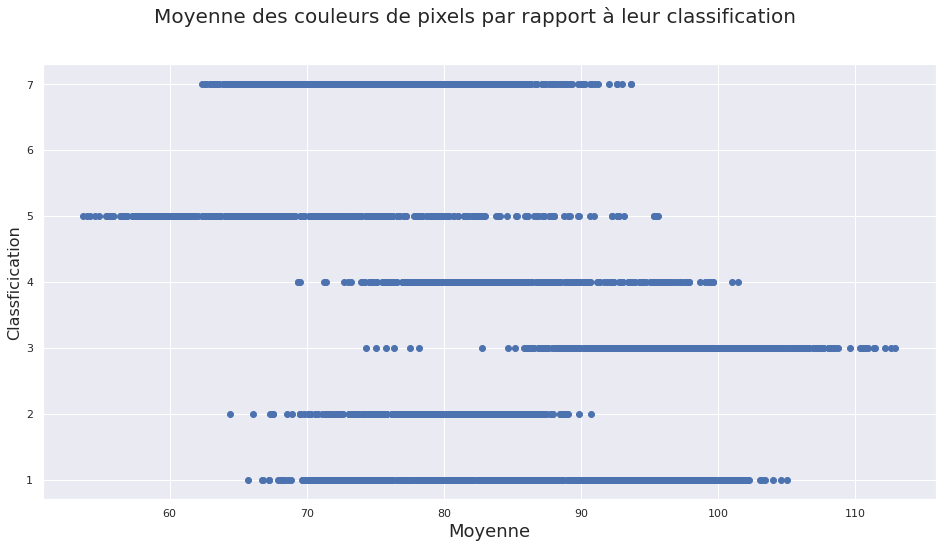

In [20]:
plot_scatter(df_compar_mean_sorted.iloc[:,[0]],df_compar_mean_sorted.iloc[:,[1]],'Moyenne des couleurs de pixels par rapport à leur classification','Moyenne','Classficication')

Après une première analyse, cela nous a permis d'identifiant quelques constats : 

  - Principalement ses valeurs numériques sont à peu pres regroupées : 
    - Classe 7 : Entre 63 et 89 (environ)
    - Classe 6 : Aucune Data 
    - Classe 5 : Entre 55 et 85 (environ)
    - Classe 4 : Entre 75 et 96 (environ)
    - Classe 3 : Entre 85 et 109 (environ)
    - Classe 2 : Entre 70 et 86 (environ)
    - Classe 1 : Entre 70 et 103 (environ)
  
  - La moyenne ne peut pas suffir pour déterminer la classification mais on a   peut en déduire que :
    - Si la moyenne du 3X3 pixel est entre (environ) 103 et + --> Sa classification sera 1 ou 3
    - Si la moyenne du 3X3 pixel est entre 0 et 70 (environ)  --> Sa classification sera 5 ou 7

* Maintenant nous allons essayer de voir si une bande parmis les 4 bandes que nous avons à un impact plus important sur la valeur de la classification final du 3X3 pixel en se servant de la moyenne des valeurs de cette meme bande sur chaque 3X3 pixel

In [21]:
#Moyenne des bandes

df_bande_Vert = statlog_trn.iloc[:,[0,4,8,12,16,20,24,28,32]] #Colonnes représentant les valeurs numériques Rouge
df_bande_Rouge = statlog_trn.iloc[:,[1,5,9,13,17,21,25,29,33]] #Colonnes représentant les valeurs numériques Verte
df_bande_NIR_1 = statlog_trn.iloc[:,[2,6,10,14,18,22,26,30,34]] #Colonnes représentant les valeurs numériques Infrarouge1
df_bande_NIR_2 = statlog_trn.iloc[:,[3,7,11,15,19,23,27,31,35]] #Colonnes représentant les valeurs numériques Infrarouge2
df_classification = statlog_trn.iloc[:,[36]]

df_bande_V_mean = df_bande_Vert.mean(axis = 1)
df_bande_R_mean = df_bande_Rouge.mean(axis = 1)
df_bande_NIR_1_mean = df_bande_NIR_1.mean(axis = 1)
df_bande_NIR_2_mean = df_bande_NIR_2.mean(axis = 1)


df_compar_mean_bande = pd.concat([df_bande_V_mean,df_bande_R_mean,df_bande_NIR_1_mean ,df_bande_NIR_2_mean,df_classification], axis=1)


df_compar_mean_bande

,0,1,2,3,37
0,90.111111,112.666667,117.555556,90.666667,3
1,84.888889,105.222222,109.000000,83.444444,3
2,83.555556,100.444444,104.333333,80.666667,3
3,82.222222,98.666667,102.888889,79.000000,3
4,80.777778,99.555556,103.888889,80.666667,3
...,...,...,...,...,...
4430,64.000000,79.555556,108.333333,94.333333,5
4431,67.444444,85.666667,107.333333,91.666667,5
4432,69.555556,90.666667,104.555556,86.888889,4
4433,71.333333,92.888889,103.555556,84.555556,4


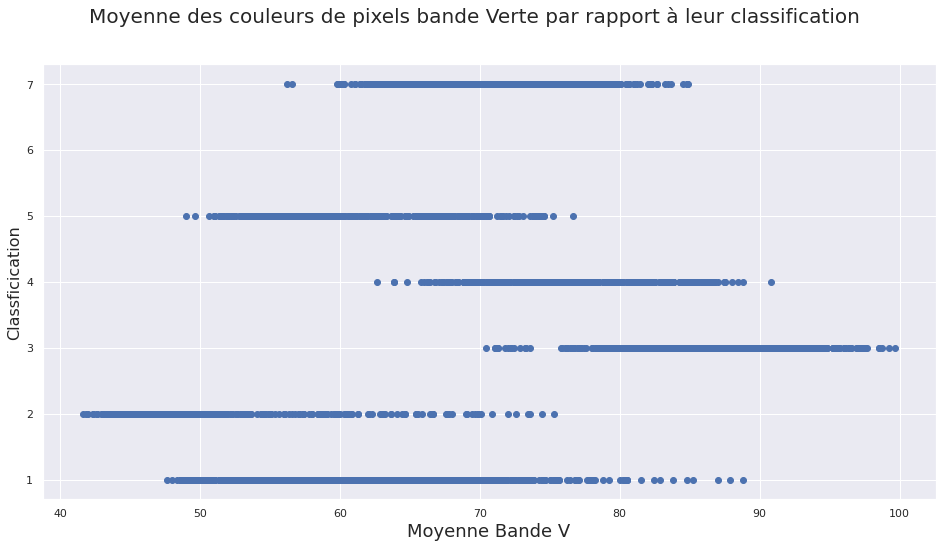

In [22]:
#Premier plot concernant le rapport moyenne bande Verte et la classification
plot_scatter(df_compar_mean_bande.iloc[:,[0]],df_compar_mean_bande.iloc[:,[4]],'Moyenne des couleurs de pixels bande Verte par rapport à leur classification','Moyenne Bande V','Classficication')

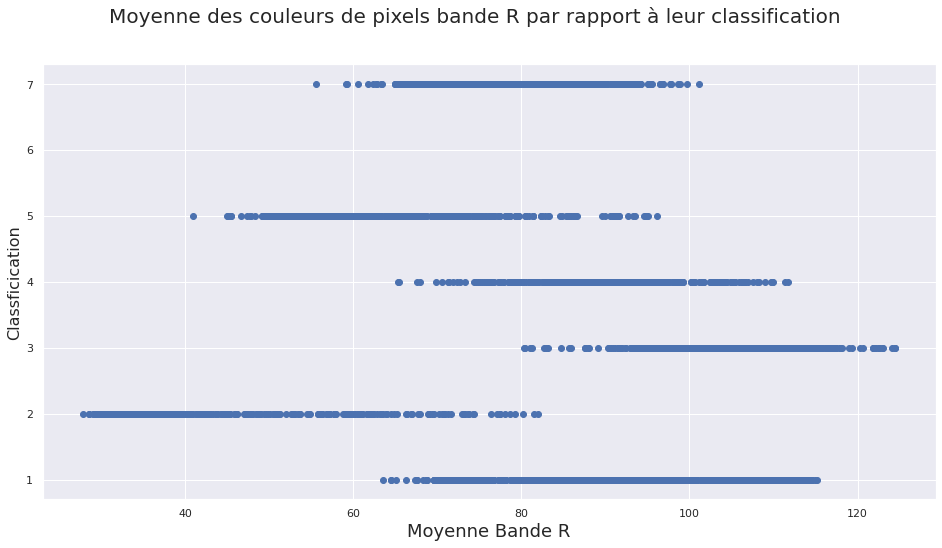

In [23]:
#Deuxième plot concernant le rapport moyenne bande Rouge et la classification
plot_scatter(df_compar_mean_bande.iloc[:,[1]],df_compar_mean_bande.iloc[:,[4]],'Moyenne des couleurs de pixels bande R par rapport à leur classification','Moyenne Bande R','Classficication')

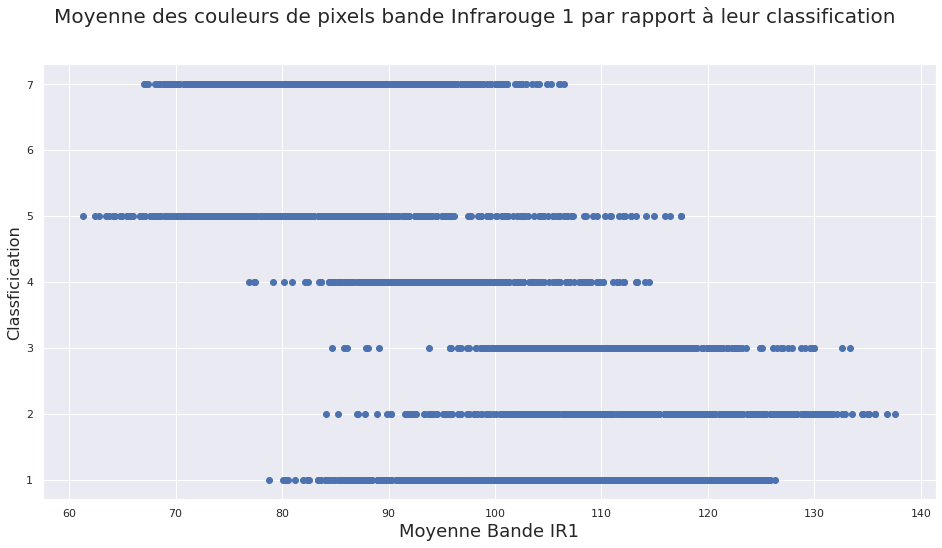

In [24]:
#Troisième plot concernant le rapport moyenne bande Infrarouge 1 et la classification
plot_scatter(df_compar_mean_bande.iloc[:,[2]],df_compar_mean_bande.iloc[:,[4]],'Moyenne des couleurs de pixels bande Infrarouge 1 par rapport à leur classification','Moyenne Bande IR1','Classficication')

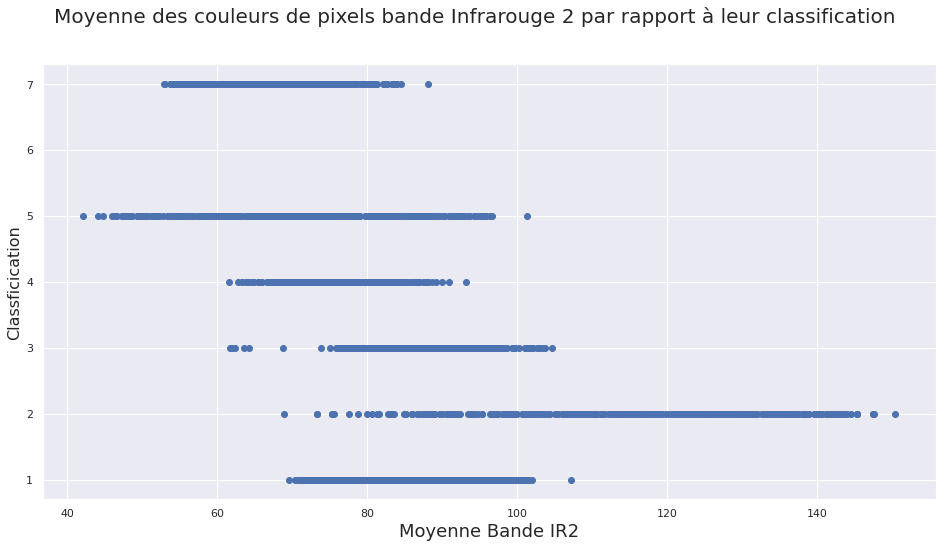

In [25]:
#Dernier plot concernant le rapport moyenne bande Infrarouge 2 et la classification
plot_scatter(df_compar_mean_bande.iloc[:,[3]],df_compar_mean_bande.iloc[:,[4]],'Moyenne des couleurs de pixels bande Infrarouge 2 par rapport à leur classification','Moyenne Bande IR2','Classficication')

- Aucune information supplémentaire n'ont pu être retenues (nous avons obtenu les memes graphe que celui de la moyenne totale des bandes) 

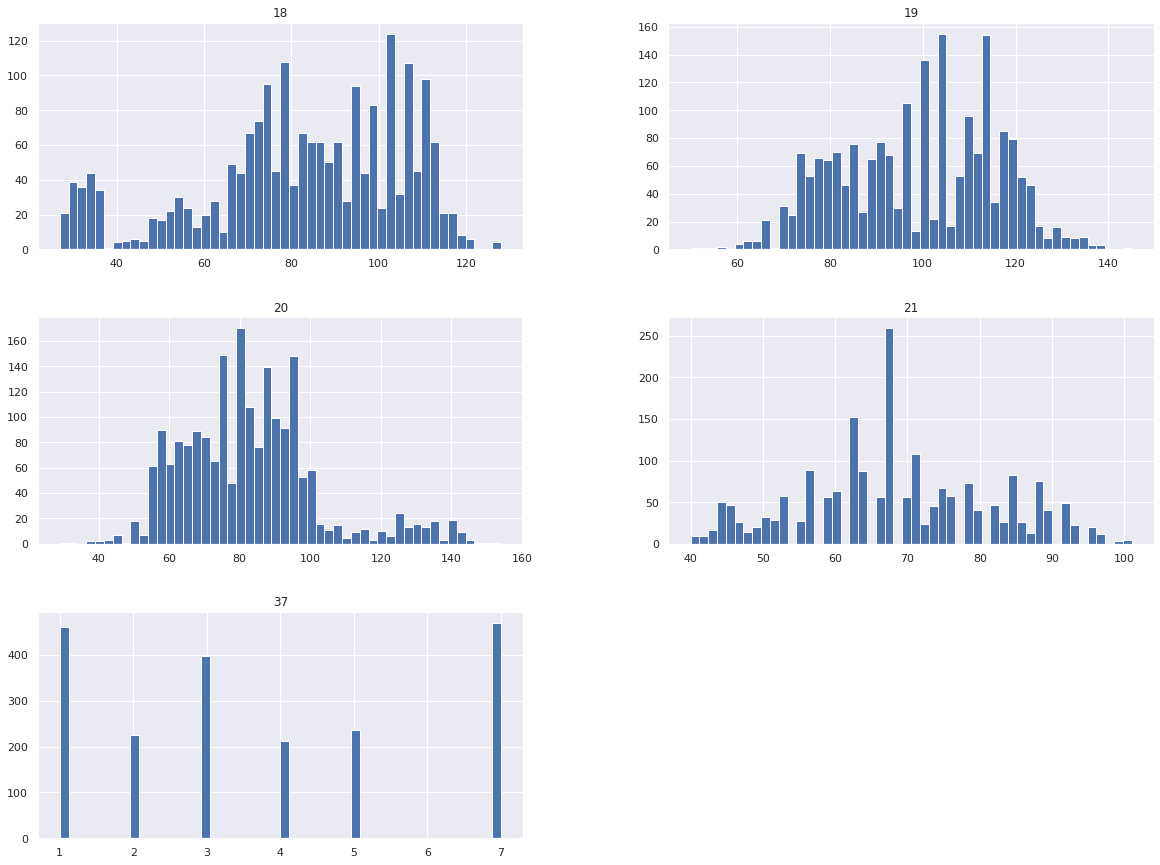

In [26]:
#Nous allons tenter d'observer la distribution des données pour notre partie de dataset concernant le pixel centrale
statlog_tst_only_main_five_colomns.hist(bins=50, figsize=(20,15))
plt.show()

Nous avons la distribution des valeurs numériques des pixels centraux de nos 3X3 pixels qui nous montrent que pour chaque bande de chaque pixel central possède un intervale de valeur plus rencontrées dans le dataset : 

- Pour la colonne 18 (Bande Verte) : Entre 70 et 110 principalement
- Pour la colonne 19 (Bande Rouge) : Entre 70 et 125 principalement
- Pour la colonne 20 (Bande NIR 1) : Entre 55 et 100 principalement
- Pour la colonne 21 (Bande NIR 2) : Il y un un pic qui se démarque des auttres data --> valeur 67 - 69 ( environ) 






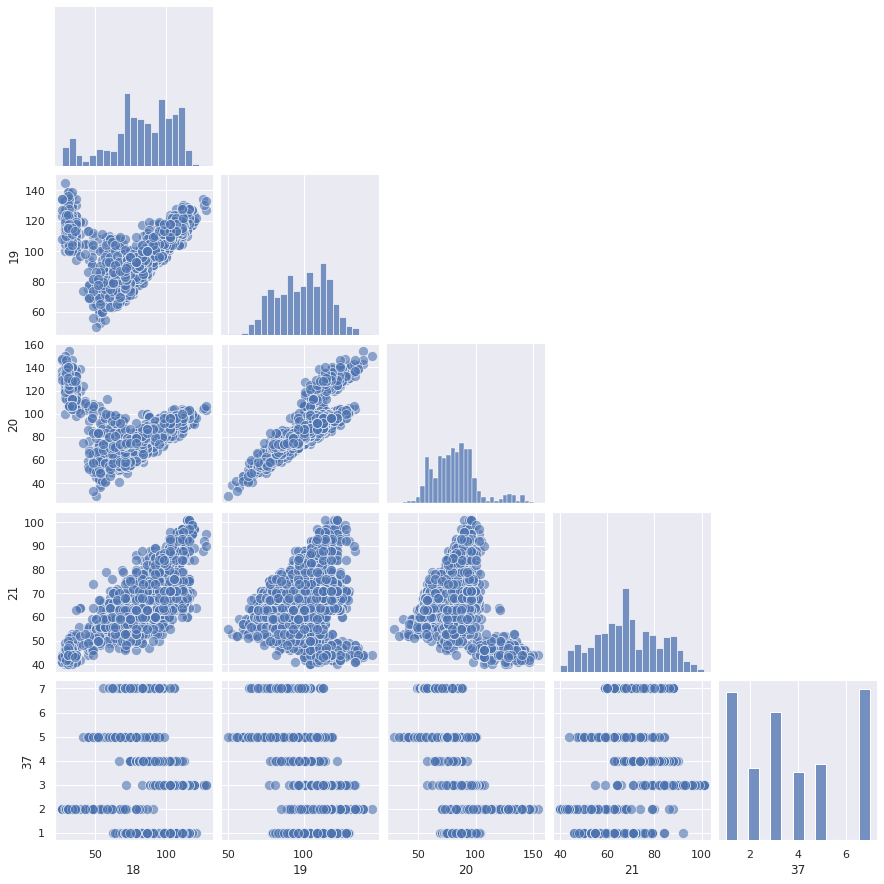

In [27]:
sns.pairplot(statlog_tst_only_main_five_colomns
                 ,vars = ['18','19','20','21','37']
                 ,diag_kind = 'hist'
                 ,plot_kws = {'alpha': 0.6, 's': 100}
                 ,corner=True)

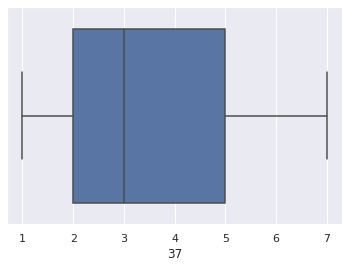

In [28]:
sns.boxplot(x=statlog_tst_only_main_five_colomns['37'])

Un box plot montre la distribution des données quantitatives de manière à faciliter les comparaisons entre les variables. La boîte montre les quartiles de l'ensemble de données tandis que les moustaches s'étendent pour montrer le reste de la distribution, à l'exception des points qui sont déterminés comme étant "aberrants" en utilisant une méthode qui est fonction de l'intervalle interquartile.

Dans notre cas, on observe que la plus pars des pixels de cette image se situe entre la classe 2 et la classe 5.

Interessons nous à la moyenne de ses valeurs

In [29]:
moyenne_classification = statlog_tst_only_main_five_colomns.iloc[:,-1:].mean()
moyenne_classification

37    3.7095
dtype: float64

En moyenne, la classification de nos pixels est à 3.70 ce qui semblerait peut être que la surface globale analysée par le satellite est entre du "grey soil" et du "damp grey soil"

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5d223ae10>],
      dtype=object)

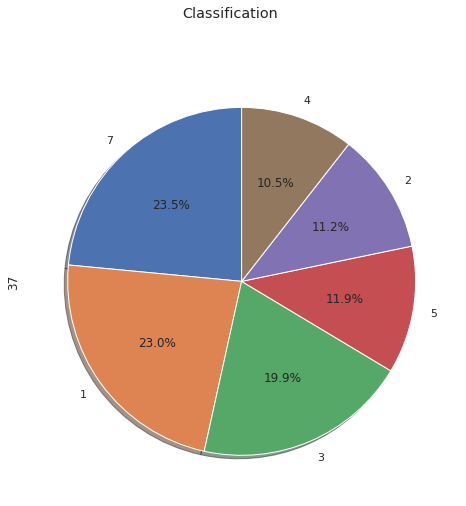

In [30]:
statlog_tst_only_main_five_colomns['37'].value_counts().plot(kind='pie', subplots=True, shadow = True,startangle=90,
figsize=(13,8), autopct='%1.1f%%', title="Classification")



Pourtant avec une observation des pourcentages de ligne appartenant à chaque classification,  il semblerait que la classification majoritaire de cette surface serait le 7 : very damp grey soil mais avec un pourcentage très proche du numéros 1 Red soil.

**Correlations:**


In [31]:
matrice_correlation = statlog_tst_only_main_five_colomns.corr()
matrice_correlation["37"].sort_values(ascending=False)

37    1.000000
21    0.141684
18   -0.186570
20   -0.651778
19   -0.702012
Name: 37, dtype: float64

La corrélation de Pearson évalue la relation linéaire entre deux variables continues. Une valeur de corrélation de 1 est considérée comme une corrélation positive totale, -1 est considéré comme une corrélation négative totale, et si 0, il n'y a pas de corrélation entre la variable.

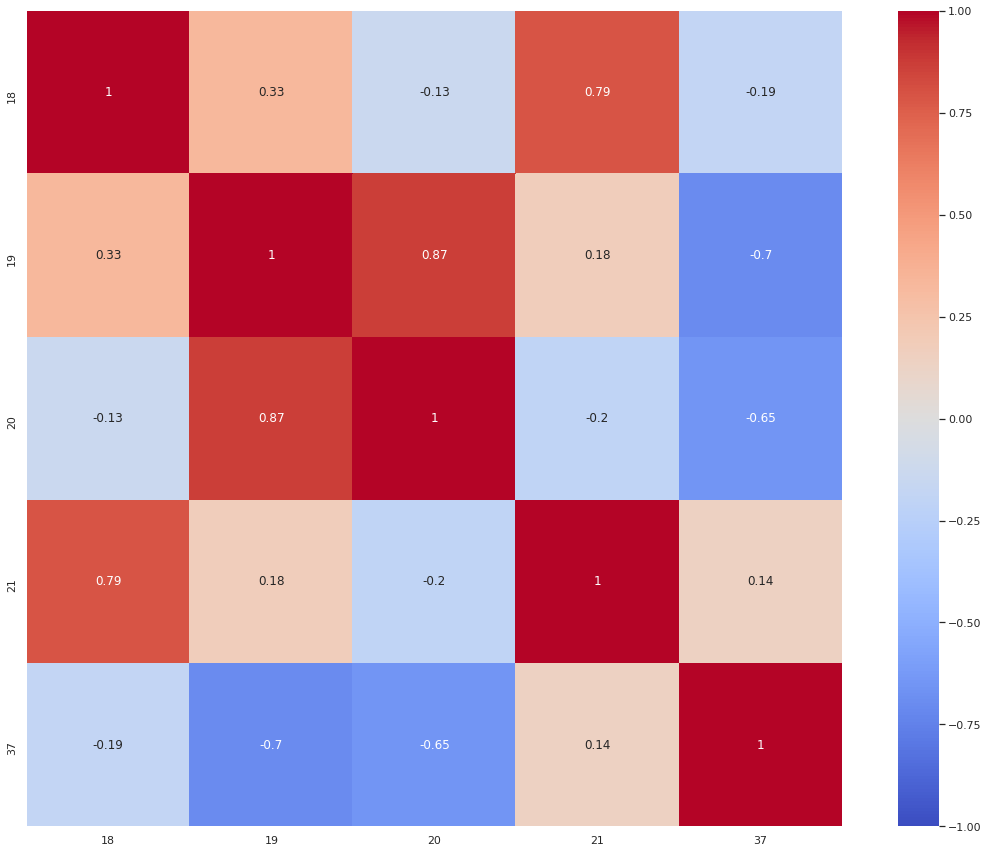

In [32]:
plt.figure(figsize=(20,15))
sns.heatmap(statlog_tst_only_main_five_colomns.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);

La corrélation positive entre "37" et "21" (0,14) nous laisse penser que la valeur numérique de la bande NIR 2 du pixel central à un impact positif sur la classification (plus la valeur numérique du de la bande NIR2 est élevé = plus la classification est élévé) 

Mais la corrélation négative entre "37" et "19"  (-0,70)  et "20" (-0,65) nous laisse penser que la valeur numérique de la bande Rouge et la bande NIR 1 du pixel central à un impact négatof sur la classification (plus la valeur numérique du de la bande NIR2 est élevé = plus la classification est faible)

On peut en déduire que les bandes Rouge et NIR1 ont un plus grand impact sur la classification que les deux autres bandes. 


**PREDICTION**

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score

In [34]:
#Separation des données de notre trainset et de notre dataset dans 4 variables
X_train  = statlog_trn.iloc[:,0:36]
Y_train = statlog_trn.iloc[:,-1]
X_test = statlog_tst.iloc[:,0:36]
Y_test = statlog_tst.iloc[:,-1]



En analysant les labels et l'évènement de multiclassification (1 à 7) ,on peut apercevoir que ses données ne sont pas bien réparties dans notre dataset (mélangé aléatoirement par les auteurs) 

La métric "f1_score" semble être la métric parfaite pour analyser la prédiction de nos modèles, afin de savoir quel modèle nous modifierons dans le but d'avoir le meilleur modèle possible pour notre dataset

Le score F1 peut être interprété comme une moyenne pondérée de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et sa pire valeur à 0. La contribution relative de la précision et du rappel au score F1 est égale.

**Ada Boost**

In [35]:
#Modèle Ada Boost
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()

ada_model.fit(X_train, Y_train)

ada_prediction = ada_model.predict(X_test)

ada_f1_score = f1_score(Y_test, ada_prediction, average='weighted')
print('f1_score : ' + str(ada_f1_score))

f1_score : 0.6913806422929347


La valeur du métric f1_score n'est pas optimale (environ 70 %). Nous allons essayer avec d'autres modèles

**Logistic Regression**


In [36]:
#Modèle LogisticRegression model
model = LogisticRegression()

model.fit(X_train, Y_train)
model_prediction = model.predict(X_test)

model_f1_score = f1_score(Y_test, model_prediction, average='weighted')
print('f1_score : ' + str(model_f1_score))


f1_score : 0.7583027139712215


La valeur du métric f1_score n'est pas optimale (environ 75 %) mais est un peu meilleur que le modèle précédent. Nous allons essayer avec d'autres modèles

**Decision Tree**

In [37]:
#Modèle Decision Tree model
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_model = DecisionTreeClassifier()

tree_model.fit(X_train, Y_train)

tree_prediction = tree_model.predict(X_test)

tree_f1_score = f1_score(Y_test, tree_prediction, average='weighted')
print('f1_score : ' + str(tree_f1_score))

f1_score : 0.8522594014077233


La valeur du métric f1_score n'est pas optimale (environ 85 %) mais est un peu meilleur que le modèle précédent.On se rapproche de quelque chose de correct mais nous allons essayer avec d'autres modèles



**Boosting**

In [38]:
#Modèle Boosting model
from sklearn.ensemble import GradientBoostingClassifier

boosting_model = GradientBoostingClassifier()

boosting_model.fit(X_train, Y_train)

boosting_prediction = boosting_model.predict(X_test)
boosting_prediction_proba = boosting_model.predict_proba(X_test)

boosting_f1_score = f1_score(Y_test, boosting_prediction, average='weighted')
print('f1_score : ' + str(boosting_f1_score))

f1_score : 0.8909649730985422


La valeur du métric f1_score a augmenté (environ 89 %) mais nous allons essayer avec d'autres modèles

**K-Neighbors**

In [39]:
#Modèle KNeighbors model
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

knn_model.fit(X_train, Y_train)

knn_prediction = knn_model.predict(X_test)

knn_f1_score = f1_score(Y_test, knn_prediction, average='weighted')
print('f1_score : ' + str(knn_f1_score))

f1_score : 0.903709462983651


La valeur du métric f1_score a augmenté (environ 90 %) mais nous allons essayer avec un dernier modèle

**Random Forest**

In [40]:
#Modèle SRandom Forest model
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(random_state=42)

forest_model.fit(X_train, Y_train)

forest_prediction = forest_model.predict(X_test)

forest_f1_score = f1_score(Y_test, forest_prediction, average='weighted')
print('f1_score : ' + str(forest_f1_score))

f1_score : 0.9085232613433516


La valeur du métric f1_score a augmenté (environ 91 %) et cette valeur nous semble acceptable. Nous allons modifier les hyperparamètres de notre Random Forest afin d'avoir un modèle sur mesure pour nos datasets.

**Comparaison des modèles**

  Resumons ces resultats dans un tableau afin de les comparer plus facilement

In [41]:
models=[AdaBoostClassifier(),LogisticRegression(),DecisionTreeClassifier(),GradientBoostingClassifier(),KNeighborsClassifier(),RandomForestClassifier(random_state=42)]
model_names=['AdaBoostClassifier','LogisticRegression','DecisionTreeClassifier','GradientBoostingClassifier','KNeighborsClassifier','RandomForestClassifier']

f1_score_tab=[]
tab={}
for model in range (len(models)):
    mod=models[model]
    mod=mod.fit(X_train,Y_train)
    test_pred=mod.predict(X_test)
    f1_score_tab.append(f1_score(Y_test, test_pred,average='weighted'))
    
tab={'Modelling Algo':model_names,'f1_score':f1_score_tab}


In [42]:
tab_result_comparison=pd.DataFrame(tab )
tab_result_comparison

,Modelling Algo,f1_score
0,AdaBoostClassifier,0.691381
1,LogisticRegression,0.758303
2,DecisionTreeClassifier,0.852331
3,GradientBoostingClassifier,0.890532
4,KNeighborsClassifier,0.903709
5,RandomForestClassifier,0.908523


Nous choisirons donc le RandomForestClassfier

**Modification of Random Forest model**


Nous allons essayer de trouver les hyperparamètres les plus optimaux avec une recherche par grille. 

In [43]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import time

In [44]:
rfc=RandomForestClassifier(random_state=42)

#Nous avons choisis de modifier les hyperparamètres : n_estimators, max_depth et min_impurity_split
param_grid = { 
    'n_estimators':range(50,500,50), #[50,100,150,200,250,300,350,400,500],
    'max_depth' : [6,8,10,20,30], #[50,100,150,200,250,300,350,400,500],
    'min_impurity_split' : [0.01,0.001,0.0005,0.0001]
} 

CV_rfc = GridSearchCV(estimator=rfc,param_grid=param_grid,cv=2, n_jobs=2, scoring='accuracy')
CV_rfc.fit(X_train, Y_train)


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [45]:
tab_mean_score = CV_rfc.cv_results_['mean_test_score']


In [46]:
 #Tableau contenant nos résultats
 CV_rfc.cv_results_

{'mean_fit_time': array([0.32954764, 0.58054161, 0.88297069, 1.25499058, 1.54368305,
        1.86960948, 2.10405552, 2.36193335, 2.66697562, 0.28718698,
        0.60634196, 0.86664927, 1.13365829, 1.41345179, 1.70343471,
        1.90954387, 2.16821003, 2.49738538, 0.28342521, 0.56780469,
        0.83831978, 1.15608084, 1.45848536, 1.67357075, 1.95625174,
        2.22080696, 2.57392836, 0.29484749, 0.57023561, 0.84638095,
        1.12801611, 1.42090952, 1.73215139, 2.02830946, 2.38958049,
        2.66148901, 0.34149945, 0.67978549, 1.01093328, 1.33141959,
        1.62950647, 1.92165577, 2.2592988 , 2.59227884, 2.93100607,
        0.31606829, 0.63806021, 0.96955335, 1.30465937, 1.61360455,
        1.95417249, 2.29300618, 2.62688625, 2.97227407, 0.33652961,
        0.67530763, 0.98574257, 1.33750641, 1.65055764, 2.01886034,
        2.30981827, 2.64533782, 3.01884317, 0.32835531, 0.66185927,
        0.97410858, 1.27885282, 1.61226153, 1.95544112, 2.33786643,
        2.67298198, 2.90011001,

In [47]:
tab_nestimator = CV_rfc.cv_results_['param_n_estimators'].data


In [48]:
tab_max_depth = CV_rfc.cv_results_['param_max_depth'].data

In [49]:
tab_min_impurity_split = CV_rfc.cv_results_['param_min_impurity_split'].data

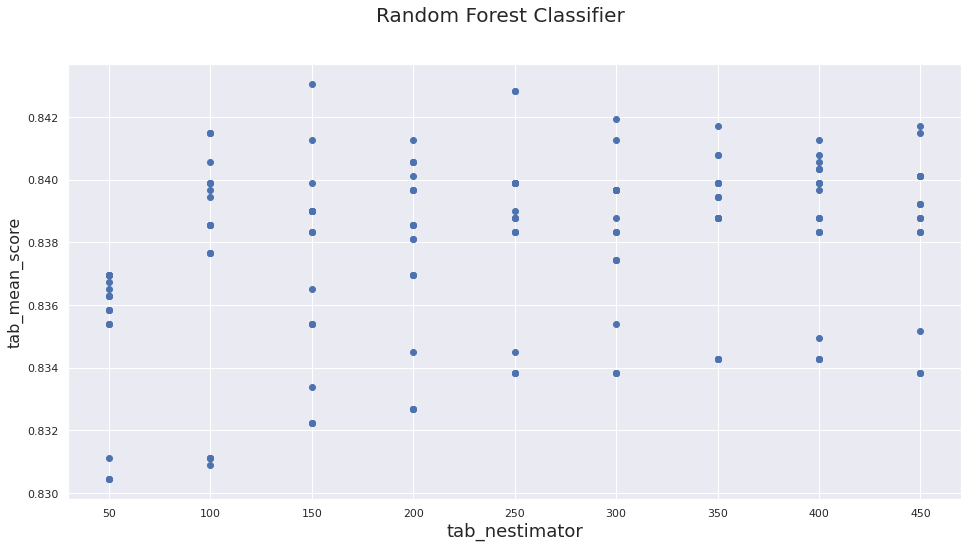

In [50]:
plot_scatter(tab_nestimator, tab_mean_score, 'Random Forest Classifier', 'tab_nestimator', 'tab_mean_score')

Avec ce graphique nous pouvons déduire que le meilleur n_estimator est 20 et qu'avec uniquement ce paramètre, notre modele random forest modifié possède un mean_score de 0,843

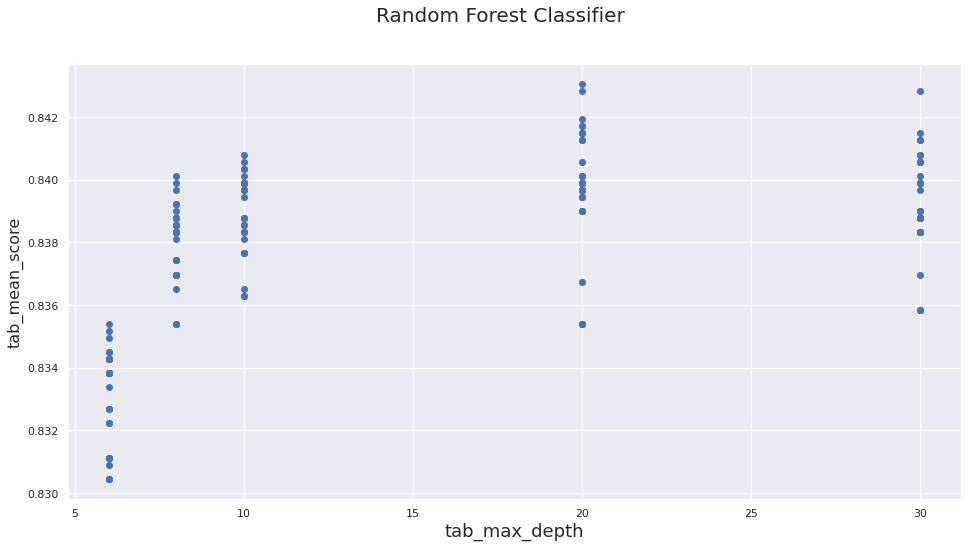

In [51]:
plot_scatter(tab_max_depth, tab_mean_score, 'Random Forest Classifier', 'tab_max_depth', 'tab_mean_score')

Avec ce graphique nous pouvons déduire que le meilleur max_depth est 20 et qu'avec uniquement ce paramètre, notre modele random forest modifié possède un mean_score de 0,843

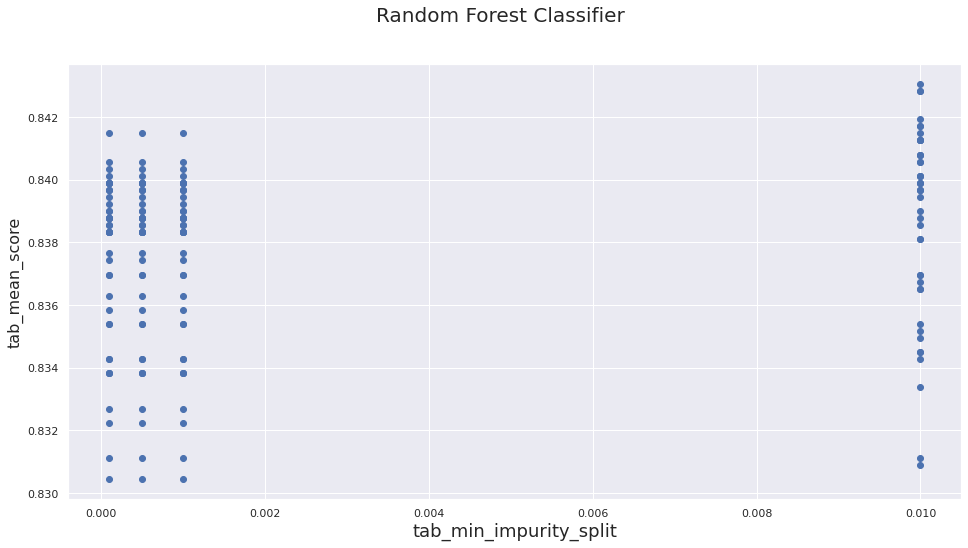

In [52]:
plot_scatter(tab_min_impurity_split, tab_mean_score, 'Random Forest Classifier', 'tab_min_impurity_split', 'tab_mean_score')

Avec ce graphique nous pouvons déduire que le meilleur min_impurity_split est 0.01 et qu'avec uniquement ce paramètre, notre modele random forest modifié possède un mean_score de 0.843

In [53]:
CV_rfc.best_params_

{'max_depth': 20, 'min_impurity_split': 0.01, 'n_estimators': 150}

La fonction .best_params_ confirme les analyses que nous venons d'établir.

**Modèle finale en utlisant les meilleurs hyperparamètres**



In [54]:
rfc1=RandomForestClassifier(random_state=42, n_estimators= 150, max_depth=20, min_impurity_split = 0.01)

In [55]:
rfc1.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=0.01,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
pred=rfc1.predict(X_test)

In [57]:
print("F1_score for Random Forest on CV data: ",f1_score(Y_test,pred,average='weighted'))

F1_score for Random Forest on CV data:  0.9113751380351022


Nous pouvons observer un léger changement de la valeur de f1_score en réglant les hyperparamètres --> f1_score de 0.9105 à 0.9114

**Modele avec le pixel central**

Pour construire notre application web avec API Flask, il serait plus facile de prendre un modèle qui fonctionne avec seulement 4 valeurs correspondant aux 4 bandes (Vert, Rouge, NIR 1 et NIR 2) de notre pixel centrale plutot que 36 valeurs. Nous allons encore utiliser le Random Forest.

In [58]:
#Separation des données de notre trainset et de notre dataset dans 4 variables
X_train_middle_pixel  = statlog_trn.iloc[:,[17,18,19,20]]
Y_train_middle_pixel = statlog_trn.iloc[:,-1]
X_test_middle_pixel = statlog_tst.iloc[:,[17,18,19,20]]
Y_test_middle_pixel = statlog_tst.iloc[:,-1]

In [59]:
rfc2=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators':range(50,500,50), #[50,100,150,200,250,300,350,400,500],
    'max_depth' : [6,8,10,20,30], #[50,100,150,200,250,300,350,400,500],
    'min_impurity_split' : [0.01,0.001,0.0005,0.0001]
} 

CV_rfc = GridSearchCV(estimator=rfc,param_grid=param_grid,cv=2, n_jobs=2, scoring='accuracy')
CV_rfc.fit(X_train_middle_pixel, Y_train_middle_pixel)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [60]:
CV_rfc.best_params_

{'max_depth': 6, 'min_impurity_split': 0.01, 'n_estimators': 350}

In [61]:
rfc3=RandomForestClassifier(random_state=42, n_estimators= 350, max_depth=6, min_impurity_split = 0.01)

In [62]:
rfc3.fit(X_train_middle_pixel,Y_train_middle_pixel)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=0.01,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [63]:
pred=rfc3.predict(X_test_middle_pixel)

In [64]:
print("F1_score for Random Forest on CV data: ",f1_score(Y_test_middle_pixel,pred,average='weighted'))

F1_score for Random Forest on CV data:  0.8373522178725797


Notre modele est fonctionnel nous pouvons le sauvegarder pour l'appeler dans l'api flask

**Enregistrement du modèle pour utilisation de l'API Flask**


In [65]:
import pickle

# save the model to drive
filename = 'finalized_model_for_middle_pixel.pkl'
pickle.dump(rfc3, open(filename, 'wb'))

**Verification de notre modèle chargé**

In [66]:
# load the model depuis le drive
loaded_model = pickle.load(open(filename, 'rb'))
score_test = loaded_model.score(X_train_middle_pixel, Y_train_middle_pixel)

print(score_test)

0.8674182638105975
